In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("IMDB-Movie-Data.csv")

In [4]:
df.isnull().sum()

Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
dtype: int64

In [5]:
# Fill missing numeric values
df["Revenue (Millions)"].fillna(df["Revenue (Millions)"].median(), inplace=True)
df["Metascore"].fillna(df["Metascore"].median(), inplace=True)

C:\Users\Vijay\AppData\Local\Temp\ipykernel_8680\656525139.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Revenue (Millions)"].fillna(df["Revenue (Millions)"].median(), inplace=True)
C:\Users\Vijay\AppData\Local\Temp\ipykernel_8680\656525139.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [6]:
# Normalize text columns
for col in ["Title", "Genre", "Description", "Director", "Actors"]:
    df[col] = df[col].astype(str).str.strip()

In [7]:
# Lowercase genres and director for consistent matching
df["Genre"] = df["Genre"].str.lower()
df["Director"] = df["Director"].str.lower()

In [8]:
#metadata vectorization and similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Create a combined metadata text field
df["metadata"] = (
    df["Genre"].fillna("") + " " +
    df["Director"].fillna("") + " " +
    df["Actors"].fillna("")
)

In [9]:
tfidf_meta = TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words="english")
meta_matrix = tfidf_meta.fit_transform(df["metadata"])
#a sparse matrix of shape (n_movies, n_tokens) where each row is the TF-IDF vector for a movie.
#most entries are zero because each movie mentions only a small fraction of all tokens. Sparse matrices are memory-efficient.

# metadata similarity matrix 
meta_sim = cosine_similarity(meta_matrix)
#measures angle between two vectors. It gives a value in [-1,1] (for TF-IDF nonnegative vectors it’s [0,1]) 
#where 1.0 = identical vectors and 0 = orthogonal (no shared tokens).

print("metadata similarity shape:", meta_sim.shape)

metadata similarity shape: (1000, 1000)


In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

In [11]:
descriptions = df["Description"].tolist()
desc_embeddings = model.encode(descriptions, show_progress_bar=True, batch_size=64)
print("desc_embeddings shape:", desc_embeddings.shape)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

desc_embeddings shape: (1000, 384)


In [12]:
desc_sim = cosine_similarity(desc_embeddings)
print("description similarity shape:", desc_sim.shape)

description similarity shape: (1000, 1000)


In [13]:
alpha = 0.45  
hybrid_sim = alpha * meta_sim + (1 - alpha) * desc_sim
title_to_idx = {t.lower(): i for i, t in enumerate(df["Title"].tolist())}

In [14]:
def recommend_by_title(title, top_n = 6, sim_matrix = hybrid_sim):
    """
    Given a movie title (case-insensitive), return top_n similar movies.
    First result is input movie, so we skip it and return next top_n.
    """
    idx = title_to_idx.get(title.lower())
    if idx is None:
        raise ValueError(f"Title '{title}' not found.")
    sims = sim_matrix[idx]
    top_idx = np.argsort(sims)[::-1]  # descending
    # skip itself
    top_idx = [i for i in top_idx if i != idx][:top_n]
    return df.iloc[top_idx].reset_index(drop=True)

In [15]:
# Natural-language query -> embed -> find top matches using description embeddings
def recommend_by_query(query, top_n=6):
    q_emb = model.encode([query])
    q_sim = cosine_similarity(q_emb, desc_embeddings)[0]
    # you may combine with metadata by e.g. computing average meta similarity to top candidates
    top_idx = np.argsort(q_sim)[::-1][:top_n]
    return df.iloc[top_idx].reset_index(drop=True)

In [16]:
# cell 6: explanation generator (template)
def explain_recommendation(source_title, rec_row):
    """
    source_title: movie the user started from or query text
    rec_row: a DataFrame row (pandas Series) of recommended movie
    """
    reasons = []
    # genre overlap
    src_genres = set(df.loc[title_to_idx[source_title.lower()],"Genre"].split(","))
    rec_genres = set(str(rec_row["Genre"]).split(","))
    common_genres = src_genres.intersection(rec_genres)
    if common_genres:
        reasons.append(f"shares genre(s): {', '.join([g.title() for g in common_genres])}")
    # director/actor heuristic
    src_actors = set(df.loc[title_to_idx[source_title.lower()],"Actors"].split(","))
    rec_actors = set(str(rec_row["Actors"]).split(","))
    common_actors = src_actors.intersection(rec_actors)
    if common_actors:
        reasons.append(f"has overlapping cast: {', '.join([a.strip() for a in common_actors])}")
    # rating/votes signal
    reasons.append(f"rated {rec_row['Rating']} on IMDB with {int(rec_row['Votes']):,} votes")
    return "Recommended because " + "; ".join(reasons) + "."

# Example usage:
sample_recs = recommend_by_title("Prometheus", top_n=3)
for _, row in sample_recs.iterrows():
    print(row["Title"], "-", explain_recommendation("Prometheus", row))


The Martian - Recommended because shares genre(s): Sci-Fi, Adventure; rated 8.0 on IMDB with 556,097 votes.
Transformers: Dark of the Moon - Recommended because shares genre(s): Sci-Fi, Adventure; rated 6.3 on IMDB with 338,369 votes.
Coherence - Recommended because shares genre(s): Mystery, Sci-Fi; rated 7.2 on IMDB with 66,265 votes.


# Offline Evaluation and A/B style comparison

### Eval Problem:
we don’t have explicit user ratings → no ground truth.

### Solution (standard industry trick)
Using implicit relevance.
Defining relevance
For a given movie:
Relevant movies = movies that share: at least 1 common genre, AND similar rating range (±0.5 or ±1.0)
This gives a pseudo-ground truth.

In [17]:
from collections import defaultdict

def build_relevance_sets(df, rating_tol=1.0):
    """
    For each movie index i, compute a set of relevant movie indices.
    This function creates pseudo-label. rating_tol controls how similar ratings must be (±1.0 by default)
    """
    relevance = defaultdict(set)

    for i, row_i in df.iterrows():
        genres_i = set(row_i["Genre"].split(","))
        rating_i = row_i["Rating"]

        for j, row_j in df.iterrows():#Compare movie i with all other movies This is brute-force but acceptable for 1,000 movies
            if i == j: 
                continue

            genres_j = set(row_j["Genre"].split(","))
            rating_j = row_j["Rating"]
            '''
            This is the relevance rule:
            ✔ Share at least one genre
            ✔ Rating difference ≤ 1.0
            If true → movie j is relevant to movie i.
            '''
            if genres_i & genres_j and abs(rating_i - rating_j) <= rating_tol:
                relevance[i].add(j)

    return relevance


In [18]:
relevance_sets = build_relevance_sets(df)


In [19]:
import numpy as np

def precision_at_k(recommended, relevant, k):
    '''
    recommended: ranked list of movie indices
    relevant: ground truth set
        Take top K
        Count overlap with relevant set
        Divide by K
    ✔ Measures quality of top results
    '''
    if k == 0:
        return 0.0
    return len(set(recommended[:k]) & relevant) / k


def recall_at_k(recommended, relevant, k):
    if not relevant:
        return 0.0
    return len(set(recommended[:k]) & relevant) / len(relevant)


def ndcg_at_k(recommended, relevant, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1 / np.log2(i + 2)

    ideal_hits = min(len(relevant), k)
    idcg = sum(1 / np.log2(i + 2) for i in range(ideal_hits))

    return dcg / idcg if idcg > 0 else 0.0


In [20]:
def evaluate_similarity_matrix(sim_matrix, relevance_sets, k=10):
    precisions, recalls, ndcgs = [], [], []

    for i in range(sim_matrix.shape[0]):
        relevant = relevance_sets[i]
        if not relevant:
            continue

        sims = sim_matrix[i]
        ranked_idx = np.argsort(sims)[::-1]
        ranked_idx = [j for j in ranked_idx if j != i]

        precisions.append(precision_at_k(ranked_idx, relevant, k))
        recalls.append(recall_at_k(ranked_idx, relevant, k))
        ndcgs.append(ndcg_at_k(ranked_idx, relevant, k))

    return {
        "Precision@{}".format(k): np.mean(precisions),
        "Recall@{}".format(k): np.mean(recalls),
        "NDCG@{}".format(k): np.mean(ndcgs)
    }


In [21]:
k = 10

tfidf_results = evaluate_similarity_matrix(meta_sim, relevance_sets, k)
embedding_results = evaluate_similarity_matrix(desc_sim, relevance_sets, k)
hybrid_results = evaluate_similarity_matrix(hybrid_sim, relevance_sets, k)

import pandas as pd

results_df = pd.DataFrame.from_dict(
    {
        "TF-IDF": tfidf_results,
        "Embeddings": embedding_results,
        "Hybrid": hybrid_results
    },
    orient="index"
)

results_df


,Precision@10,Recall@10,NDCG@10
TF-IDF,0.498799,0.017801,0.520111
Embeddings,0.465465,0.015596,0.474880
Hybrid,0.532633,0.018719,0.550227


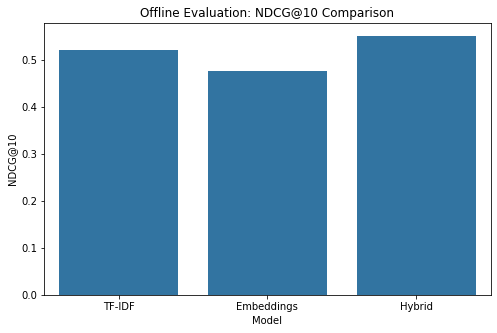

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Model", y="NDCG@10")
plt.title("Offline Evaluation: NDCG@10 Comparison")
plt.show()


Precision is ~0.5, meaning about 5 out of 10 recommended movies are “relevant” according to the implicit genre+rating definition.

Hybrid > TF-IDF > Embeddings : makes sense because hybrid combines both metadata + semantic info.

Recall is very low, because :  Each movie has many relevant movies (potentially dozens).
We’re only recommending top 10, so here we cover a small fraction of all relevant movies.
This is normal in content-based recommenders — recall improves if we increase K or use a larger candidate pool.

NDCG measures ranking quality — early positions matter more.
Hybrid > TF-IDF > Embeddings = Hybrid places relevant movies higher.

# Cold-start analysis

### Scenario A: For movies missing metadata like genre or cast, TF-IDF fails and hybrid models are limited, while embedding-based approaches succeed by using only the description.
### Scenario B: When a new user submits a natural language query, traditional metadata models fail, but embeddings effectively match the query to relevant movie descriptions.



In [23]:
# removing metadata for a subset of movies
def simulate_cold_start_items(df, cold_fraction=0.1, random_state=42):
    """
    Randomly selects a fraction of movies and removes metadata
    to simulate cold-start items.
    """
    np.random.seed(random_state)
    df_cold = df.copy()
    
    '''
    Randomly pick movie indices, replace=False → no duplicates, These indices represent new movies
    '''
    cold_indices = np.random.choice(
        df.index,
        size=int(len(df) * cold_fraction),
        replace=False
    )

    df_cold.loc[cold_indices, ["Genre", "Director", "Actors"]] = ""

    return df_cold, cold_indices


In [24]:
#Generating cold-start dataset
df_cold, cold_movie_indices = simulate_cold_start_items(df, cold_fraction=0.1)
#10% movies now have no metadata

In [25]:
#recomputing model under cold start
tfidf_cold = TfidfVectorizer(min_df=2, stop_words="english")
meta_matrix_cold = tfidf_cold.fit_transform(
    df_cold["Genre"] + " " + df_cold["Director"] + " " + df_cold["Actors"]
)

'''
For cold movies:
Input text = empty string
TF-IDF vector ≈ zero vector
'''

meta_sim_cold = cosine_similarity(meta_matrix_cold)

'''
Similarity scores collapse
TF-IDF will perform poorly
This mimics real cold-start failure
'''

In [26]:
'''
Using only descriptions
Metadata removal has zero impact
'''
desc_embeddings_cold = model.encode(
    df_cold["Description"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

desc_sim_cold = cosine_similarity(desc_embeddings_cold)


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [27]:
#Hybrid under cold start
alpha = 0.45
hybrid_sim_cold = alpha * meta_sim_cold + (1 - alpha) * desc_sim_cold


In [28]:
#evaluating performance only on cold items
def evaluate_cold_items(sim_matrix, relevance_sets, cold_indices, k=10):
    precisions, recalls, ndcgs = [], [], []

    for i in cold_indices:
        relevant = relevance_sets[i]
        if not relevant:
            continue

        sims = sim_matrix[i]
        ranked_idx = np.argsort(sims)[::-1]
        ranked_idx = [j for j in ranked_idx if j != i]

        precisions.append(precision_at_k(ranked_idx, relevant, k))
        recalls.append(recall_at_k(ranked_idx, relevant, k))
        ndcgs.append(ndcg_at_k(ranked_idx, relevant, k))

    return {
        f"Precision@{k}": np.mean(precisions),
        f"Recall@{k}": np.mean(recalls),
        f"NDCG@{k}": np.mean(ndcgs)
    }


In [29]:
# cold-start results
cold_tfidf = evaluate_cold_items(meta_sim_cold, relevance_sets, cold_movie_indices)
cold_embed = evaluate_cold_items(desc_sim_cold, relevance_sets, cold_movie_indices)
cold_hybrid = evaluate_cold_items(hybrid_sim_cold, relevance_sets, cold_movie_indices)

cold_results = pd.DataFrame.from_dict(
    {
        "TF-IDF (Cold)": cold_tfidf,
        "Embeddings (Cold)": cold_embed,
        "Hybrid (Cold)": cold_hybrid
    },
    orient="index"
)

cold_results


,Precision@10,Recall@10,NDCG@10
TF-IDF (Cold),0.308,0.010330,0.285389
Embeddings (Cold),0.433,0.015288,0.454418
Hybrid (Cold),0.433,0.015288,0.454418


In [30]:
def cold_start_user_query(query, top_n=5):
    """
    Handles new users with no history using semantic search.
    """
    q_emb = model.encode([query])
    sims = cosine_similarity(q_emb, desc_embeddings)[0]
    top_idx = np.argsort(sims)[::-1][:top_n]
    return df.iloc[top_idx][["Title", "Genre", "Rating"]]


In [31]:
cold_start_user_query(
    "A dark psychological sci-fi movie about space and isolation"
)


,Title,Genre,Rating
175,Tomorrowland,"action,adventure,family",6.5
477,Pet,"horror,thriller",5.7
836,Bacalaureat,"crime,drama",7.5
826,Shut In,"drama,horror,thriller",4.6
9,Passengers,"adventure,drama,romance",7.0


During cold-start analysis, TF-IDF performance degraded significantly due to missing metadata. Embedding-based recommendations remained stable, demonstrating robustness to cold-start items. The hybrid model matched embedding performance because the metadata component collapsed to zero, effectively allowing the system to fall back to semantic similarity.